# Selección de variables 

In [1]:

##
#https://jdvelasq.github.io/courses/notebooks/pyspark/2-04-pyspark-SparkSQL.html
#https://guru99.es/pyspark-tutorial/
## findspark permite usar pyspark (interfaz de Python a Spark),
## desde cualquier programa escrito en Python.
##
import findspark
findspark.init()
##
## A continuación se inicializan las variables obligatorias
## requeridas para trabajar con Spark desde Python:
##
##  SparkContext representa la conexión al cluster de Spark.
##  SparkConf representa la configuración particular de una aplicación
##     escrita en Spark.
##  SparkSession representa la conexión para trabajar con SQL.
##
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

sparkConf = SparkConf().setAppName("ml_spark")
sc = SparkContext(conf=sparkConf)
spark = SparkSession(sc)

# Cargar el conjunto de datos

In [2]:
##
## Row representa una fila en un RDD
##
from pyspark.sql import Row
##
## Crea un DataFrame a partir del archivo con
## formato CSV
##
df = spark.read.load("D:\\CLASES\ELECTIVA 3 BigData\\Clase5_Ejercicos_Spark\\DATOS\\data_icfes_ml_tumaco.csv",
                     format="csv",
                     sep="|",
                     inferSchema= True,
                     encoding="utf-8",
                     header="true")
df.printSchema()

root
 |-- estu_edad: double (nullable = true)
 |-- estu_nacimiento_dia: double (nullable = true)
 |-- estu_nacimiento_mes: double (nullable = true)
 |-- estu_nacimiento_anno: double (nullable = true)
 |-- estu_zona_reside: double (nullable = true)
 |-- estu_area_reside: double (nullable = true)
 |-- cole_valor_pension: double (nullable = true)
 |-- estu_trabaja: double (nullable = true)
 |-- fami_estrato_vivienda: double (nullable = true)
 |-- estu_veces_estado: double (nullable = true)
 |-- fami_educa_padre: double (nullable = true)
 |-- fami_educa_madre: double (nullable = true)
 |-- fami_ocup_padre: double (nullable = true)
 |-- fami_ocup_madre: double (nullable = true)
 |-- fami_nivel_sisben: double (nullable = true)
 |-- fami_pisos_hogar: double (nullable = true)
 |-- fami_personas_hogar: double (nullable = true)
 |-- fami_telefono_fijo: double (nullable = true)
 |-- fami_celular: double (nullable = true)
 |-- fami_internet: double (nullable = true)
 |-- fami_servicio_television: 

Podemos contar cuántos eventos hay para cada clase para ver si el conjunto de datos está desequilibrado.

In [4]:
df.groupBy('clase').count().show()

+-----+-----+
|clase|count|
+-----+-----+
|    1|  331|
|    0| 1592|
+-----+-----+



Como podemos ver, el conjunto de datos parece estar equilibrado, por lo que podemos dividirlo en marcos de datos de prueba y de entrenamiento.
La fracción de eventos utilizada para la etapa de entrenamiento es $ 0.8 $ y el resto $ 0.2 $ se usará para probar nuestro clasificado

In [5]:
train, test = df.randomSplit([0.8,0.2])

In [6]:
print('Registros training {}'.format(train.count()))
print('Registros validation {}'.format(test.count()))

Registros training 1541
Registros validation 382


# Preparación de variables

In [7]:
feature = train.columns
feature.remove('clase')
feature

['estu_edad',
 'estu_nacimiento_dia',
 'estu_nacimiento_mes',
 'estu_nacimiento_anno',
 'estu_zona_reside',
 'estu_area_reside',
 'cole_valor_pension',
 'estu_trabaja',
 'fami_estrato_vivienda',
 'estu_veces_estado',
 'fami_educa_padre',
 'fami_educa_madre',
 'fami_ocup_padre',
 'fami_ocup_madre',
 'fami_nivel_sisben',
 'fami_pisos_hogar',
 'fami_personas_hogar',
 'fami_telefono_fijo',
 'fami_celular',
 'fami_internet',
 'fami_servicio_television',
 'fami_computador',
 'fami_lavadora',
 'fami_nevera',
 'fami_horno',
 'fami_dvd',
 'fami_microondas',
 'fami_automovil',
 'fami_ing_fmiliar_mensual',
 'estu_anos_preescolar',
 'estu_reprobo_primero',
 'estu_anos_colegio_actual',
 'estu_cuantos_cole_estudio',
 'estu_razon_retiro',
 'estu_total_alumnos_curso',
 'estu_prestigioinstitucion',
 'estu_por_ubicacion',
 'estu_por_unicaqueofrece',
 'estu_por_amigosestudiando',
 'estu_por_otrarazon',
 'estu_por_orientacionvocacional',
 'estu_por_tradicionfamiliar',
 'estu_por_influenciaalguien',
 'cole

Para crear un vector que contenga todas las características, podemos usar VectorAssembler: necesitamos instanciarlo especificando la columna que contiene las características y la columna de salida que contendrá el vector ensamblado. Después de esto, podemos transformar (crear los vectores ensamblados)
el marco de datos train y de test.

In [8]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=feature, outputCol='features')
train = assembler.transform(train)
test = assembler.transform(test)

In [9]:
train.select('features').take(1)

[Row(features=SparseVector(91, {0: 9.0, 1: 8.0, 2: 8.0, 3: 2000.0, 4: 10.0, 5: 2.0, 6: 8.0, 8: 1.0, 10: 9.0, 11: 10.0, 12: 21.0, 13: 26.0, 14: 1.0, 15: 3.0, 16: 3.0, 18: 1.0, 23: 1.0, 25: 1.0, 28: 1.0, 44: 42.95, 45: 1.0, 47: 1.0, 51: 1.0, 53: 1.0, 79: 1.0}))]

In [10]:
train.select('features').show(5)

+--------------------+
|            features|
+--------------------+
|(91,[0,1,2,3,4,5,...|
|(91,[0,1,2,3,4,5,...|
|(91,[0,1,2,3,4,5,...|
|(91,[0,1,2,3,4,5,...|
|(91,[0,1,2,3,4,5,...|
+--------------------+
only showing top 5 rows



# Random Forest

Los bosques aleatorios son métodos de aprendizaje por conjuntos para problemas de clasificación y regresión. En un bosque aleatorio, estamos combinando una gran cantidad de árboles independientes entrenados sobre subconjuntos aleatorios e igualmente distribuidos de los datos obtenidos mediante el muestreo con reemplazo del conjunto de datos original.

Como punto de partida, entrenaremos un bosque aleatorio con los mejores parámetros de la guia v4

In [11]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol='clase', featuresCol='features',
                           numTrees=500,maxDepth = 5,
                            minInstancesPerNode=5,
                            impurity='entropy',
                            minWeightFractionPerNode=0.005,
                            minInfoGain=0
                           )

In [12]:
rf = rf.fit(train)

# Ahora podemos usar nuestro modelo entrenado para predecir las instancias de prueba.

In [13]:
pred = rf.transform(test)

In [14]:
pred.printSchema()

root
 |-- estu_edad: double (nullable = true)
 |-- estu_nacimiento_dia: double (nullable = true)
 |-- estu_nacimiento_mes: double (nullable = true)
 |-- estu_nacimiento_anno: double (nullable = true)
 |-- estu_zona_reside: double (nullable = true)
 |-- estu_area_reside: double (nullable = true)
 |-- cole_valor_pension: double (nullable = true)
 |-- estu_trabaja: double (nullable = true)
 |-- fami_estrato_vivienda: double (nullable = true)
 |-- estu_veces_estado: double (nullable = true)
 |-- fami_educa_padre: double (nullable = true)
 |-- fami_educa_madre: double (nullable = true)
 |-- fami_ocup_padre: double (nullable = true)
 |-- fami_ocup_madre: double (nullable = true)
 |-- fami_nivel_sisben: double (nullable = true)
 |-- fami_pisos_hogar: double (nullable = true)
 |-- fami_personas_hogar: double (nullable = true)
 |-- fami_telefono_fijo: double (nullable = true)
 |-- fami_celular: double (nullable = true)
 |-- fami_internet: double (nullable = true)
 |-- fami_servicio_television: 

In [15]:
pred.select('clase', 'prediction', 'probability').show(5)

+-----+----------+--------------------+
|clase|prediction|         probability|
+-----+----------+--------------------+
|    0|       0.0|[0.85143469234619...|
|    0|       0.0|[0.81699260451063...|
|    0|       0.0|[0.87468729373304...|
|    0|       0.0|[0.56474068242214...|
|    0|       0.0|[0.83626452545227...|
+-----+----------+--------------------+
only showing top 5 rows



In [16]:
pred_pd = pred.select(['clase', 'prediction', 'probability']).toPandas()

In [18]:
pred_pd.head()

,clase,prediction,probability
0,0,0.0,"[0.8514346923461916, 0.14856530765380838]"
1,0,0.0,"[0.8169926045106364, 0.18300739548936365]"
2,0,0.0,"[0.874687293733048, 0.12531270626695204]"
3,0,0.0,"[0.5647406824221429, 0.43525931757785696]"
4,0,0.0,"[0.8362645254522711, 0.16373547454772885]"


Necesitamos convertir la predicción de la columna en una lista, porque ahora es de tipo VectorDense. Crearemos una nueva columna encoded_label que usaremos para trazar la curva roc.

In [19]:
import numpy as np
pred_pd['probability'] = pred_pd['probability'].map(lambda x: list(x))
pred_pd['encoded_clase'] = pred_pd['clase'].map(lambda x: np.eye(2)[int(x)])

pred_pd.head()

,clase,prediction,probability,encoded_clase
0,0,0.0,"[0.8514346923461916, 0.14856530765380838]","[1.0, 0.0]"
1,0,0.0,"[0.8169926045106364, 0.18300739548936365]","[1.0, 0.0]"
2,0,0.0,"[0.874687293733048, 0.12531270626695204]","[1.0, 0.0]"
3,0,0.0,"[0.5647406824221429, 0.43525931757785696]","[1.0, 0.0]"
4,0,0.0,"[0.8362645254522711, 0.16373547454772885]","[1.0, 0.0]"


In [20]:
y_pred = np.array(pred_pd['probability'].tolist())
y_true = np.array(pred_pd['encoded_clase'].tolist())

In [21]:
from sklearn.metrics import auc, roc_curve

fpr, tpr, threshold = roc_curve(y_score=y_pred[:,0], y_true=y_true[:,0])
auc = auc(fpr, tpr)

print('AUC: {:.3f}'.format(auc))

AUC: 0.767


<IPython.core.display.Javascript object>


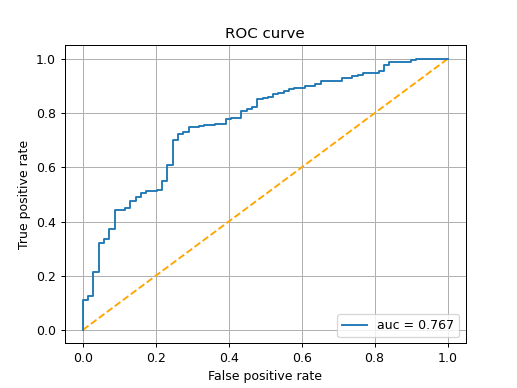

In [22]:
import matplotlib.pyplot as plt 
from pyspark.sql.functions import col
%matplotlib notebook

plt.figure()
plt.plot([0,1], [0,1], 'k--', color='orange')
plt.plot(fpr, tpr, label='auc = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Una ventaja de utilizar métodos de conjunto (como Random Forest y Gradient Boosting) es que es muy fácil extraer las puntuaciones de importancia de cada atributo. Como sugiere el nombre, la importancia de una característica indica cuán útil fue una característica durante la construcción de los árboles. Cuanto más se utiliza 
un atributo para tomar decisiones dentro de un árbol, mayor es su importancia.

In [26]:
n=len(feature)
n

91

<IPython.core.display.Javascript object>


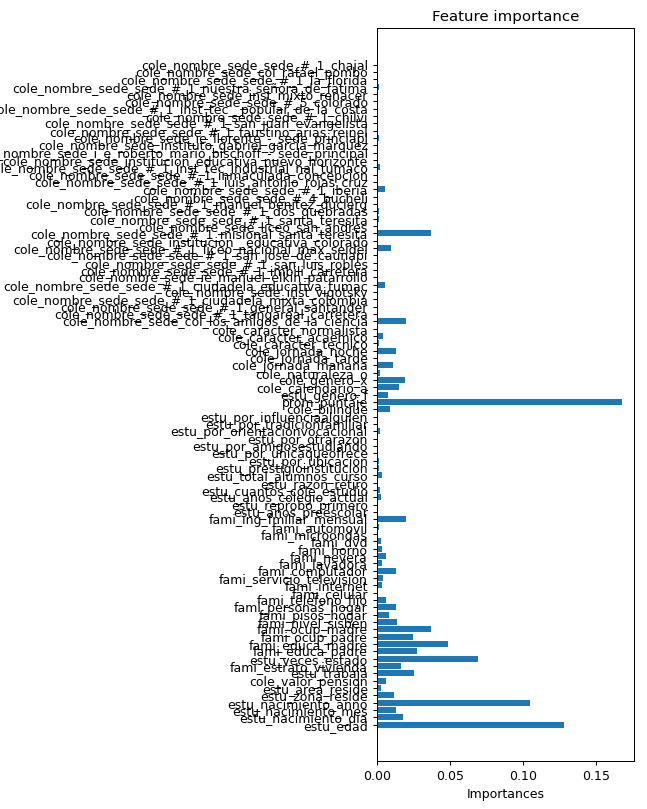

In [27]:
fig, ax = plt.subplots(figsize=(8,10))
ax.barh(range(n),rf.featureImportances.toArray())
ax.set_yticks(range(n))
ax.set_yticklabels(feature)
ax.set_xlabel('Importances')
ax.set_title('Feature importance')
plt.tight_layout()
plt.show()

In [28]:
import pandas as pd
df_imp=pd.DataFrame({'variables': feature, 'importancia': rf.featureImportances.toArray()})
df_imp.head()

,variables,importancia
0,estu_edad,0.128329
1,estu_nacimiento_dia,0.018138
2,estu_nacimiento_mes,0.013362
3,estu_nacimiento_anno,0.105095
4,estu_zona_reside,0.011731


Ordenar variables de acuerdo a su importancia 

In [29]:
df_imp.sort_values(by='importancia',ascending=False)

,variables,importancia
44,prom_puntaje,0.167935
0,estu_edad,0.128329
3,estu_nacimiento_anno,0.105095
9,estu_veces_estado,0.069161
11,fami_educa_madre,0.049024
...,...,...
61,cole_nombre_sede_ie_manuel_elkin_patarrollo,0.000000
62,cole_nombre_sede_sede_#_1_imbili_carretera,0.000000
64,cole_nombre_sede_sede_#_1_san_jose_de_caunapi,0.000000
66,cole_nombre_sede_institucion__educativa_colorado,0.000000


# Filtrar variables de poca importancia 

In [30]:
df_imp_filter=df_imp[df_imp['importancia']>0]
df_imp_filter=df_imp_filter.sort_values(by='importancia',ascending=False)
df_imp_filter

,variables,importancia
44,prom_puntaje,0.167935
0,estu_edad,0.128329
3,estu_nacimiento_anno,0.105095
9,estu_veces_estado,0.069161
11,fami_educa_madre,0.049024
...,...,...
42,estu_por_influenciaalguien,0.000066
68,cole_nombre_sede_liceo_san_andres,0.000054
77,cole_nombre_sede_institucion_educativa_nuevo_h...,0.000048
83,cole_nombre_sede_sede_#_1_chilvi,0.000038


<IPython.core.display.Javascript object>


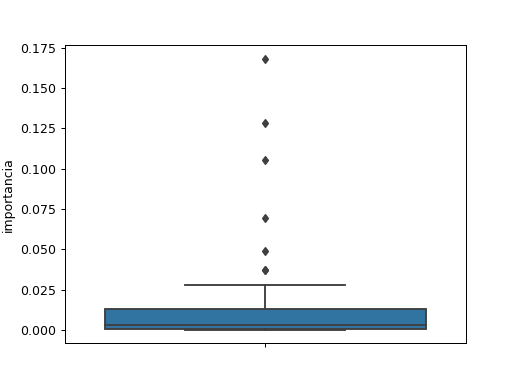

In [31]:
import seaborn as sns
%matplotlib notebook
ax = sns.boxplot(y=df_imp_filter["importancia"])

In [32]:
df_imp_filter.describe()

,importancia
count,77.000000
mean,0.012987
std,0.027763
min,0.000033
25%,0.000629
50%,0.003040
75%,0.013130
max,0.167935


In [33]:
important_features=df_imp_filter['variables'].to_list()
important_features

['prom_puntaje',
 'estu_edad',
 'estu_nacimiento_anno',
 'estu_veces_estado',
 'fami_educa_madre',
 'fami_ocup_madre',
 'cole_nombre_sede_sede_#_1_misional_santa_teresita',
 'fami_educa_padre',
 'estu_trabaja',
 'fami_ocup_padre',
 'cole_nombre_sede_col_los_amigos_de_la_ciencia',
 'fami_ing_fmiliar_mensual',
 'cole_genero_x',
 'estu_nacimiento_dia',
 'fami_estrato_vivienda',
 'cole_calendario_a',
 'fami_nivel_sisben',
 'estu_nacimiento_mes',
 'fami_personas_hogar',
 'fami_computador',
 'cole_jornada_noche',
 'estu_zona_reside',
 'cole_jornada_manana',
 'cole_nombre_sede_sede_#_1_liceo_nacional_max_seidel',
 'cole_bilingue',
 'fami_pisos_hogar',
 'estu_genero_f',
 'cole_valor_pension',
 'fami_nevera',
 'fami_telefono_fijo',
 'cole_nombre_sede_sede_#_1_iberia',
 'cole_nombre_sede_sede_#_1_ciudadela_educativa_tumac',
 'cole_caracter_acaemico',
 'fami_servicio_television',
 'fami_internet',
 'fami_lavadora',
 'estu_total_alumnos_curso',
 'fami_horno',
 'fami_dvd',
 'estu_anos_colegio_actua

In [34]:
assembler = VectorAssembler(inputCols=important_features, outputCol='important_features')

train = assembler.transform(train)
test = assembler.transform(test)

In [35]:
rf_all = RandomForestClassifier(labelCol='clase', featuresCol='features',
                           numTrees=500,maxDepth = 5,
                            minInstancesPerNode=5,
                            impurity='entropy',
                            minWeightFractionPerNode=0.005,
                            minInfoGain=0
                           )

In [36]:
%%time
model = rf_all.fit(train)

Wall time: 3.82 s


Ahora podemos guardar el modelo. Se guardará como un archivo  parquet.

In [37]:
model.write().overwrite().save(path='D:\\CLASES\\ELECTIVA 3 BigData\\modelos')

cargar modelo

In [38]:
from pyspark.ml.classification import RandomForestClassificationModel
loaded_rf = RandomForestClassificationModel\
        .load('D:\\CLASES\\ELECTIVA 3 BigData\\modelos')

In [39]:
pred_full = loaded_rf.transform(test)
pred_pd_full = pred_full.select(['clase', 'prediction', 'probability']).toPandas()


In [40]:
pred_pd_full['probability'] = pred_pd_full['probability'].map(lambda x: list(x))
pred_pd_full['encoded_clase'] = pred_pd_full['clase'].map(lambda x: np.eye(2)[int(x)])

y_pred = np.array(pred_pd_full['probability'].tolist())
y_true = np.array(pred_pd_full['encoded_clase'].tolist())

<IPython.core.display.Javascript object>


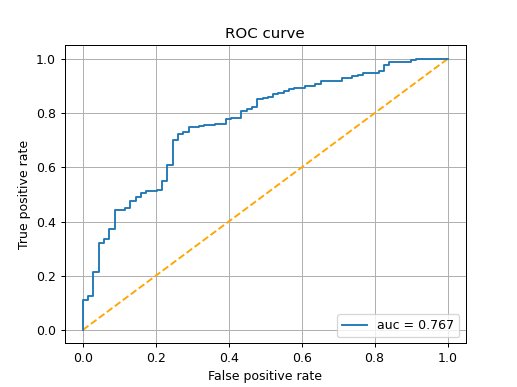

In [41]:
from sklearn.metrics import auc, roc_curve
fpr, tpr, threshold = roc_curve(y_score=y_pred[:,0], y_true=y_true[:,0])
auc = auc(fpr, tpr)

plt.figure()
plt.plot([0,1], [0,1], 'k--', color='orange')
plt.plot(fpr, tpr, label='auc = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Gradient-Boosting Trees

Al igual que Random Forest, Gradient Boosting Trees es una técnica de aprendizaje automático que produce un modelo de predicción en forma de un conjunto de árboles de predicción débiles. A diferencia del bosque aleatorio, GBT optimiza una función de costo en un espacio de funciones eligiendo iterativamente una función que apunta en la dirección del gradiente negativo.

In [42]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol='clase', featuresCol='features', maxIter=50, maxDepth=5)

In [43]:
%%time
gbt_model = gbt.fit(train)

Wall time: 13.7 s


In [44]:
pred_gbt = gbt_model.transform(test)
pred_pd_gbt = pred_gbt.select(['clase', 'prediction', 'probability']).toPandas()

In [45]:
pred_pd_gbt['probability'] = pred_pd_gbt['probability'].map(lambda x: list(x))
pred_pd_gbt['encoded_clase'] = pred_pd_gbt['clase'].map(lambda x: np.eye(2)[int(x)])

y_pred_gbt = np.array(pred_pd_gbt['probability'].tolist())
y_true_gbt = np.array(pred_pd_gbt['encoded_clase'].tolist())

<IPython.core.display.Javascript object>


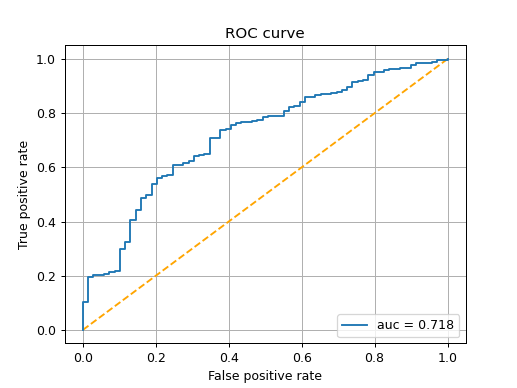

In [46]:
from sklearn.metrics import auc, roc_curve
fpr_gbt, tpr_gbt, threshold_gbt = roc_curve(y_score=y_pred_gbt[:,0], y_true=y_true_gbt[:,0])
auc_gbt = auc(fpr_gbt, tpr_gbt)

plt.figure()
plt.plot([0,1], [0,1], 'k--', color='orange')
plt.plot(fpr_gbt, tpr_gbt, label='auc = {:.3f}'.format(auc_gbt))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()